In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.optimize import root


def minkowski_distance(point_a: np.ndarray, point_b: np.ndarray, p: float) -> np.ndarray:
    '''
    Minkowski distance function.
    '''
    absolute_difference = np.abs(point_a - point_b)
    power_in_sum = np.power(absolute_difference, p)
    summa = np.sum(power_in_sum)
    return np.power(summa, 1/p)


def minkowski_loss(cluster: np.ndarray, centroid: np.ndarray, p: float) -> np.ndarray:
    '''
    SGD Minkowski Loss function.
    Return the coordinate sum of the Minkowski differences
    Formula: [∑_j (xji - ci)^p]
    '''
    loss = []
    for point in cluster:
        absolute_difference = np.abs(point - centroid)
        power_in_sum = np.power(absolute_difference, p)
        loss.append(power_in_sum)
    loss = np.array(loss)
    dim_loss = np.sum(loss, axis=0)
    return dim_loss


def minkowski_1_derivative(parameter_to_solve: np.ndarray, cluster: np.ndarray, p: float):
    return np.sum([np.sign(point-parameter_to_solve)*np.abs(point-parameter_to_solve)**(p-1) for point in cluster], axis=0)


class KMeans:
    def __init__(self, n_clusters, max_iter=100, p=2):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.p = p
        self.centroids = []
        self.labels = []

    def fit(self, X):
        # initialize centroids randomly
        self.centroids = [X[i] for i in np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            clusters = [[] for _ in range(self.n_clusters)]
            self.labels = []

            # assign each data point to the closest centroid
            for x in X:
                distances_to_each_cebtroid = [minkowski_distance(x, centroid, self.p) for centroid in self.centroids]
                closest_centroid = np.argmin(distances_to_each_cebtroid)
                clusters[closest_centroid].append(x)
                self.labels.append(closest_centroid)

            # update centroids using the specified optimizer
            for cluster_id, cluster in enumerate(clusters):
                cluster = np.array(cluster)
                if len(cluster) == 0:
                    continue
                if self.p == 2:
                    self.centroids[cluster_id] = np.mean(cluster, axis=0)
                elif self.p == 1:
                    self.centroids[cluster_id] = np.median(cluster, axis=0)
                elif self.p > 1:
                    '''
                    SGD optimizer
                    Amorim, Renato. (2012). Feature Weighting for Clustering: Using K-Means and the Minkowski Metric. 
                    '''
                    learning_rate = 0.01
                    grad_descent = 0.1
                    n_iters = 50
                    centroid = np.mean(cluster, axis=0)

                    for sgd_iteration in range(n_iters):
                        if sgd_iteration == n_iters / 2:
                            learning_rate *= grad_descent
                        loss = minkowski_loss(cluster, centroid, self.p)
                        grad = np.gradient(loss, axis=0)
                        centroid -= learning_rate * grad
                    self.centroids[cluster_id] = centroid
                elif 0 < self.p < 1:
                    '''
                    Find extremum of minkowski function by root of 1 derivative.
                    '''
                    sol = root(minkowski_1_derivative, np.mean(cluster, axis=0), args=(cluster, self.p), method='hybr')
                    self.centroids[cluster_id] = sol.x
                else:
                    raise ValueError(f'Unsupported value of p: {self.p}')
                    # if self.optimizer == 'SLSQP':
                    #     bounds = [(None, None)] * self.centroids[j].shape[0]
                    #     self.centroids[j] = minimize(
                    #         lambda x: minkowski_distance(x, cluster, self.p),
                    #         self.centroids[j].flatten(),
                    #         method=self.optimizer,
                    #         bounds=bounds
                    #     ).x.copy()
                    # elif self.optimizer in ('Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'trust-constr'):
                    #     self.centroids[j] = minimize(lambda x: minkowski_distance(x, cluster, self.p), self.centroids[j], method=self.optimizer).x.copy()

        return self.centroids, self.labels

In [2]:
from typing import List, Tuple, Optional
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
import matplotlib.pyplot as plt
import pandas as pd


def generate_gaussian_clusters(
    centroid_locations: List[List],
    sigma: float,
    dimension: int,
    n_points_per_cluster: int = 100
    ) -> Tuple[np.ndarray, np.ndarray]:

    clusters = []
    labels = []
    randomizer = np.random.default_rng()

    for cluster_id, centroid_location in enumerate(centroid_locations):
        cluster_size = (n_points_per_cluster, dimension)
        labels_size = (n_points_per_cluster, )

        cluster_points = randomizer.normal(
            loc=centroid_location,
            scale=sigma,
            size=cluster_size
        )

        cluster_labels = np.full(shape=labels_size, fill_value=cluster_id)

        clusters.append(cluster_points)
        labels.append(cluster_labels)

    return np.concatenate(clusters), np.concatenate(labels)


def generate_cluster_centroids(
    dimension: int,
    n_clusters: int,
    distance_factor: float
    ) -> np.ndarray:

    centroid_locations = np.stack([np.random.random(dimension) * distance_factor for _ in range(n_clusters)])
    return centroid_locations


def get_one_experiment_metrics(
    true_labels: List,
    pred_labels: List,
    p: Optional[float] = None,
    time: Optional[float] = None) -> pd.DataFrame:

    ari = adjusted_rand_score(true_labels, pred_labels)
    ami = adjusted_mutual_info_score(true_labels, pred_labels)

    data = {'Adjusted Rand Index': ari, 'Adjusted Mutual Information': ami}
    if time:
        data['Time'] = time
    index = [f'Experiment with p: {p}'] if p else [f'Experiment'] 
    frame = pd.DataFrame(data, index)
    return frame


class MetricTable:

    def __init__(self) -> None:
        self.frames = []

    def add_frame(self, frame: pd.DataFrame) -> None:
        self.frames.append(frame)

    def print(self) -> None:
        print(pd.concat(self.frames, join="inner"))


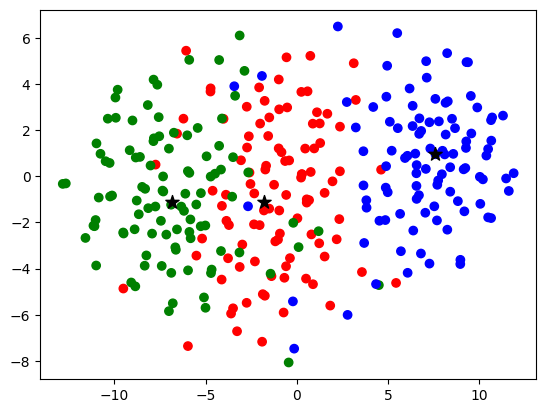

In [3]:
from sklearn.manifold import TSNE


dimension = 20 # dimensionality
n_clusters = 3 # Number of clusters
distance_factor = 0.2 # allows to increase distances between cluster centroids
sigma = 0.1 # STD distribution
n_points_per_cluster = 100

centroid_locations = generate_cluster_centroids(
    dimension=dimension,
    n_clusters=n_clusters,
    distance_factor=distance_factor
)

clusters, labels = generate_gaussian_clusters(
    dimension=dimension,
    sigma=sigma,
    centroid_locations=centroid_locations,
    n_points_per_cluster=n_points_per_cluster
)


def print_clusters(clusters: np.ndarray,
                   labels: np.ndarray,
                   centroids: Optional[np.ndarray] = None) -> None:

    color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow', 4: 'purple'}

    colors = [color_map[label] for label in labels]
    tsne = TSNE(n_components=2, random_state=42)

    if not isinstance(centroids, type(None)):
        concuted = np.concatenate((clusters, np.array(centroids)), axis=0)
        clusters_tsne = tsne.fit_transform(concuted)

        plt.scatter(clusters_tsne[:-len(centroids),0], clusters_tsne[:-len(centroids),1], c=colors)
        plt.scatter(clusters_tsne[-len(centroids):,0], clusters_tsne[-len(centroids):,1], marker='*', s=100, c='black')
    else:
        clusters_tsne = tsne.fit_transform(clusters)
        plt.scatter(clusters_tsne[:,0], clusters_tsne[:,1], c=colors)
    plt.show()

print_clusters(clusters, labels, centroid_locations)

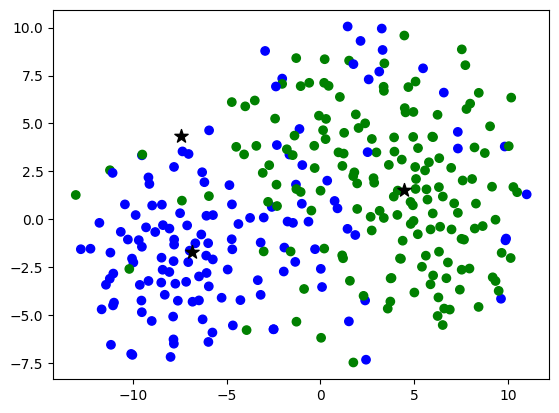

                        Adjusted Rand Index  Adjusted Mutual Information  \
Experiment with p: 0.5             0.283536                     0.270774   

                             Time  
Experiment with p: 0.5  12.682627  


In [4]:
import time

frames = []

metrics = MetricTable()

for p in [0.5]:
    experiment_time = time.perf_counter()
    kmeans = KMeans(n_clusters=n_clusters, p=p)
    generated_centroids, generated_labels = kmeans.fit(clusters)
    frame = get_one_experiment_metrics(labels, generated_labels, p, time=time.perf_counter()-experiment_time)
    metrics.add_frame(frame)
    print_clusters(clusters, generated_labels, generated_centroids)

metrics.print()